**Given the number of airline passengers (in thousands per month) this month, what is the number of airline passengers (in thousands per month) next month? State your observations on the RMSE calculated over the training and test datasets in comparison to the original dataset.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving AirPassengers.csv to AirPassengers.csv


In [ ]:
df = pd.read_csv('AirPassengers.csv',
                 index_col='Month',
                 parse_dates=True)

In [ ]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Month'>

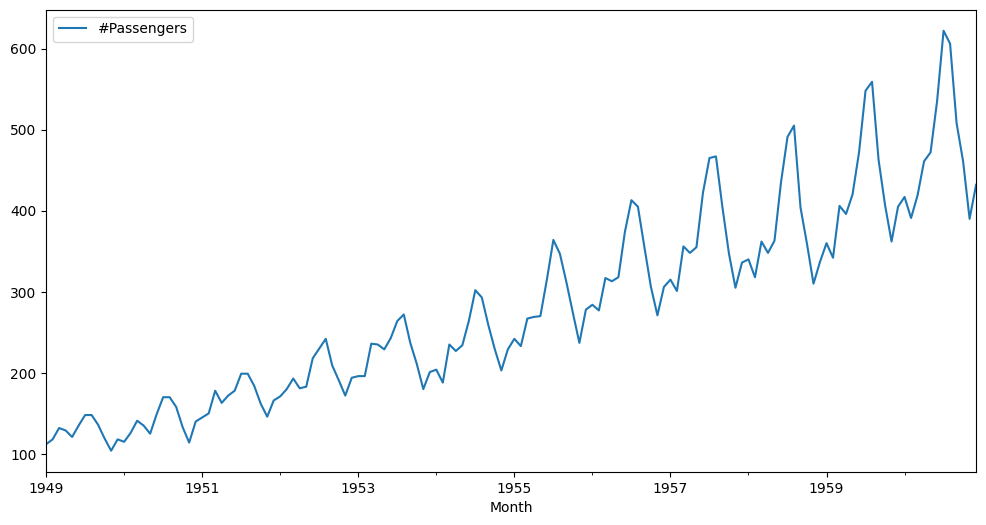

In [ ]:
# Plotting graph b/w Passengers and Month
df.plot(figsize=(12, 6))

(<Figure size 640x480 with 4 Axes>, None)

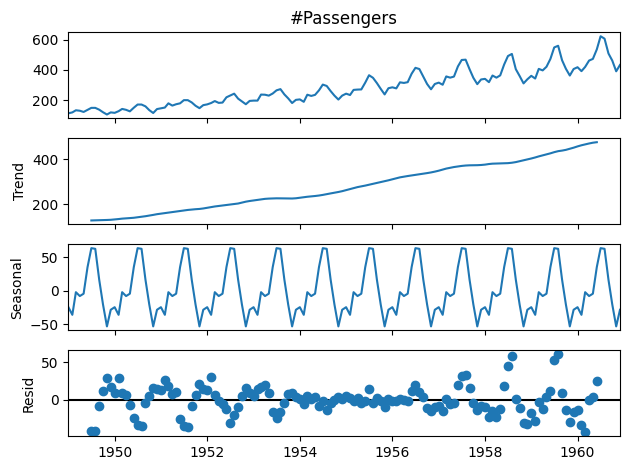

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['#Passengers'])
results.plot(), plt.tight_layout()

In [ ]:
dataset = df.values
dataset = dataset.astype('float32')

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model.summary()

Epoch 1/100
94/94 - 3s - loss: 0.0385 - 3s/epoch - 34ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0186 - 296ms/epoch - 3ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0137 - 196ms/epoch - 2ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0125 - 211ms/epoch - 2ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0116 - 185ms/epoch - 2ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0105 - 192ms/epoch - 2ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0096 - 202ms/epoch - 2ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0087 - 188ms/epoch - 2ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0080 - 180ms/epoch - 2ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0071 - 189ms/epoch - 2ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0062 - 180ms/epoch - 2ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0054 - 190ms/epoch - 2ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0047 - 192ms/epoch - 2ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0041 - 247ms/epoch - 3ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0035 - 182ms/epoch - 2ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0030 - 221ms/epoc

We observe that the model has an average error of about 23 passengers (in thousands per month) on the training dataset and about 49 passengers (in thousands per month) on the test dataset.

In [18]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 6ms/step
Train Score: 22.69 RMSE
Test Score: 48.74 RMSE


The current plot shows the original dataset in blue, the predictions for the training dataset in saffron, and the predictions for the unseen test dataset in green.

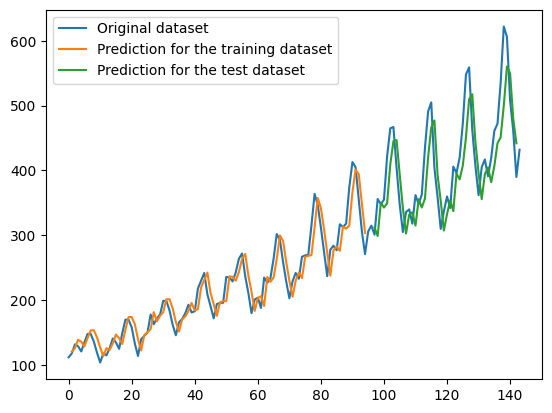

In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(["Original dataset", "Prediction for the training dataset", "Prediction for the test dataset"], loc ="upper left")
plt.show()

We can observe that the model did an excellent job of fitting both the training and test datasets.